In [ ]:
%pip install geopandas
%pip install libpysal
%pip install cityseer
%pip install pyvisgraph
%pip install folium
%pip install mkdocs

In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import geopandas
import subprocess
import libpysal as lp
import numpy as np
from cityseer.tools.util import project_geom
from cityseer.metrics.visibility import _prepare_epsg_code
from shapely.geometry import mapping
import pyvisgraph as vg
import folium

In [2]:
nush: geopandas.GeoDataFrame = geopandas.read_file("../data/josm/main.geojson")
nush['level'] = nush['level'].apply(lambda x: x.split("-") if x.find("-")!=-1 else [x,x])
nush['indoor'] = nush['indoor'].fillna(nush['highway'])
neighbor = lp.weights.Queen.from_dataframe(nush, use_index=False)
nush['neighbor'] = neighbor.to_adjlist(drop_islands=True).groupby("focal").agg(list)['neighbor']
nush.reset_index(inplace=True)
nush

c:\Users\picokatx\Documents\pathfinding-project\pathfinding-project\.venv\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 3 islands with ids: 406, 615, 725.
  W.__init__(self, neighbors, ids=ids, **kw)


,index,name,highway,lanes,service,level,access,amenity,crossing,door,landuse,lanes:forward,lanes:backward,oneway,utility,indoor,geometry,neighbor
0,0,Block D L5 Toilet (Female),None,None,None,"[5, 5]",None,toilets,None,None,None,None,None,None,None,room,"POLYGON ((103.76913 1.30657, 103.76913 1.30649...","[40, 82, 84, 143, 156, 176, 191, 230, 323, 334..."
1,1,None,None,None,None,"[6, 6]",yes,None,None,yes,None,None,None,None,None,None,"POLYGON ((103.76909 1.30720, 103.76909 1.30719...","[2, 162, 183, 319, 359, 505, 576, 646, 724, 80..."
2,2,None,None,None,None,"[5, 5]",None,None,None,None,None,None,None,None,None,corridor,"POLYGON ((103.76919 1.30702, 103.76922 1.30702...","[1, 7, 10, 17, 41, 43, 63, 65, 66, 67, 69, 91,..."
3,3,Block F Left Stairway to Stage,steps,None,None,"[2, 2]",None,None,None,None,None,None,None,None,None,steps,"POLYGON ((103.76957 1.30588, 103.76957 1.30587...","[122, 147, 148, 180, 264, 303, 434, 464, 510, ..."
4,4,Void Deck,None,None,None,"[6, 6]",None,None,None,None,void_deck,None,None,None,None,area,"POLYGON ((103.76920 1.30748, 103.76920 1.30750...","[128, 178, 198, 218, 351, 512, 574, 600, 617, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,893,Reception (Library),None,None,None,"[1, 1]",None,library,None,None,None,None,None,None,None,area,"POLYGON ((103.76978 1.30626, 103.76978 1.30628...","[13, 30, 364, 651, 704, 715, 751, 760, 877]"
894,894,Study Corner (Computer Lab),None,None,None,"[4, 4]",None,study_corner,None,None,None,None,None,None,None,area,"POLYGON ((103.76902 1.30634, 103.76898 1.30634...","[31, 42, 104, 158, 167, 190, 206, 293, 331, 37..."
895,895,Computer Lab 5,None,None,None,"[4, 4]",None,lab,None,None,None,None,None,None,None,room,"POLYGON ((103.76900 1.30620, 103.76900 1.30626...","[44, 165, 212, 219, 220, 227, 234, 248, 346, 3..."
896,896,None,None,None,None,"[5, 5]",yes,None,None,yes,None,None,None,None,None,None,"POLYGON ((103.76938 1.30692, 103.76938 1.30690...","[71, 385, 586, 604, 782]"


C:\Users\picokatx\AppData\Local\Temp\ipykernel_10636\709204907.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


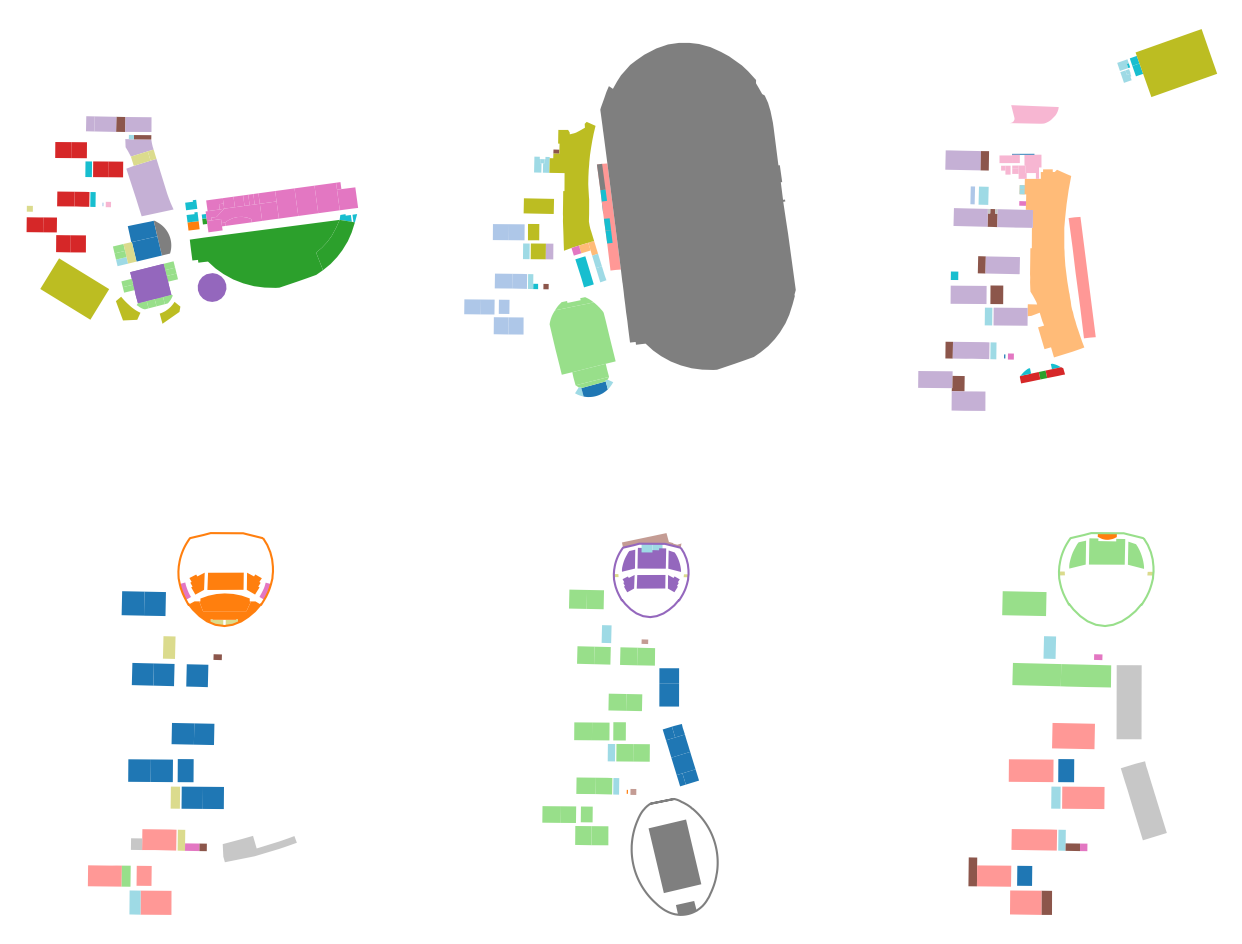

In [3]:

fig, ax = plt.subplots(2, 3, figsize=(16, 12))
level = 1
for ax in ax.flat:
    amenities = nush[~nush['amenity'].isna() &
    ((level>=nush['level'].str[0].astype(float)) & (level<=nush['level'].str[1].astype(float)))
    ]
    ax = amenities.plot(figsize=(16,16), column="amenity", cmap="tab20", ax=ax)
    ax.set_axis_off()
    fig.add_subplot(ax)
    level+=1
fig.show()

<Axes: >

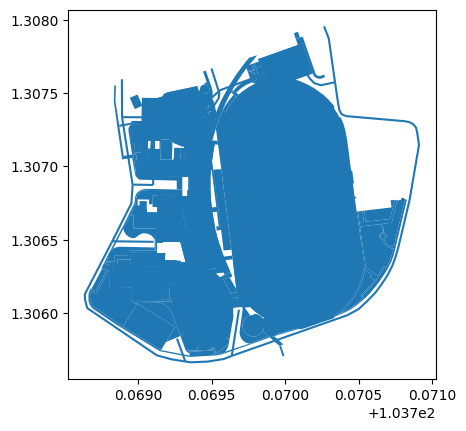

In [4]:
nush.plot()

In [8]:
from shapely.ops import unary_union
level = 5
elm = nush[((level>=nush['level'].str[0].astype(float)) & (level<=nush['level'].str[1].astype(float)))
    & ((nush['indoor']=='corridor') | (nush['indoor']=='area') | (nush['indoor']=='steps') | (nush['indoor']=='elevator')) & (nush['landuse']!="void") & ((nush['landuse']=="void_deck") | (nush['landuse'].isna()))
]

minx, miny, maxx, maxy = elm.bounds['minx'].min()+1e-6, elm.bounds['miny'].min()+1e-6, elm.bounds['maxx'].max()-1e-6, elm.bounds['maxy'].max()-1e-6
bounds = shapely.geometry.polygon.Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])
polys = []
for poly in list(bounds.difference(unary_union(elm['geometry'])).geoms): #elm['geometry']:
    for ptdb in mapping(poly)['coordinates']:
        polys.append([vg.Point(pt[0], pt[1]) for pt in ptdb])
# for poly in mapping(unary_union(elm['geometry']))['coordinates']:
#     for ptdb in poly:
#         polys.append([vg.Point(pt[0], pt[1]) for pt in ptdb])
# polys = [[vg.Point(0.0,1.0), vg.Point(3.0,1.0), vg.Point(1.5,4.0)],
#          [vg.Point(3.0,4.0), vg.Point(7.0,4.0), vg.Point(5.5,8.0)]]

g = vg.VisGraph()
g.build(polys)

start_point = vg.Point(103.7688753,1.3063346)
end_point = vg.Point(103.7689985, 1.3071000) #103.7690985, 1.3070299
shortest_path = g.shortest_path(start_point, end_point)
# shortest_path = g.find_visible(start_point)

geopath = [[point.y, point.x] for point in shortest_path]
layout = [[[point.y, point.x] for point in poly] for poly in polys]


geomap  = folium.Map([0, 0])
geomap.fit_bounds([[1.3055, 0.0685+103.7], [1.3080, 0.0710+103.7]])

# visibility = g.find_visible(shortest_path[7])
# rays = [[point.y, point.x] for point in visibility]
# for ray in rays:
#     folium.PolyLine([[start_point.y, start_point.x], ray], fill_color="red").add_to(geomap)

for poly in layout:
    folium.Polygon(poly, fill_color="red").add_to(geomap)
folium.PolyLine(geopath, color="red").add_to(geomap)

# for point in geopath:
#     folium.Marker(point, popup=str(point)).add_to(geomap)
# Add a Mark on the start and positions in a different color
# folium.Marker(geopath[0], popup=str(start_point), icon=folium.Icon(color='red')).add_to(geomap)
# folium.Marker(geopath[-1], popup=str(end_point), icon=folium.Icon(color='red')).add_to(geomap)
geomap

100%|██████████| 56/56 [00:04<00:00, 13.04it/s]


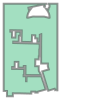

In [36]:
list(bounds.difference(unary_union(elm['geometry'])).geoms)[3]

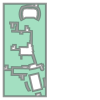

In [104]:
list(bounds.difference(unary_union(elm['geometry'])).geoms)[0]

In [115]:
mapping(bounds.difference(shapely.geometry.polygon.Polygon(mapping(list(bounds.difference(unary_union(elm['geometry'])).geoms)[0:1][0])['coordinates'][1])))

{'type': 'Polygon',
 'coordinates': (((103.76882647037, 1.30755838824),
   (103.76963939603, 1.30755838824),
   (103.76963939603, 1.30577515145),
   (103.76882647037, 1.30577515145),
   (103.76882647037, 1.30627989114),
   (103.76882647037, 1.30755838824)),
  ((103.76885050702, 1.30627958415),
   (103.7688575942, 1.30627949736),
   (103.76891208603, 1.30627911833),
   (103.76898273959, 1.30627849262),
   (103.76898177718, 1.30620162266),
   (103.76897913178, 1.30620139614),
   (103.76897871083, 1.30618769701),
   (103.76905886569, 1.30618688755),
   (103.76909341787, 1.30618672808),
   (103.76913220877, 1.30618630535),
   (103.76913241737, 1.30614091842),
   (103.76916760356, 1.30614100765),
   (103.76916736906, 1.30618634942),
   (103.76916744603, 1.30617501549),
   (103.76916793202, 1.30609773932),
   (103.76921192753, 1.30609725112),
   (103.76921070056, 1.30617459259),
   (103.76925348973, 1.30617465225),
   (103.76925826697, 1.30618931443),
   (103.76926033837, 1.30619519105),
   

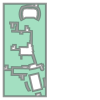

In [74]:
list(bounds.difference(unary_union(elm['geometry'])).geoms)[0:1][0]

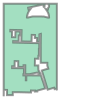

In [54]:
from shapely import affinity
affinity.scale(list(bounds.difference(unary_union(elm['geometry'])).geoms)[2], 10,10)

In [251]:
mapping(list(bounds.difference(unary_union(elm['geometry'])).geoms)[1])

{'type': 'Polygon',
 'coordinates': (((103.76959170262, 1.30609725112),
   (103.76921192753, 1.30609725112),
   (103.76921070056, 1.30617459259),
   (103.76921062178, 1.30620428285),
   (103.76905881999, 1.30620445169),
   (103.76900406689, 1.30620491992),
   (103.76900468956, 1.30626176695),
   (103.76900479351, 1.30627125678),
   (103.76900490834, 1.30627809825),
   (103.76900512467, 1.30629511598),
   (103.76900534293, 1.30631654417),
   (103.7692667766, 1.30631241608),
   (103.76928982563, 1.30631209797),
   (103.7693222156, 1.30631173195),
   (103.76932797297, 1.3062911804),
   (103.76933516449, 1.30629262124),
   (103.76943002707, 1.30631162722),
   (103.76943689373, 1.30631300297),
   (103.76952687517, 1.30633994971),
   (103.76954672025, 1.30629005676),
   (103.76954918168, 1.30628614854),
   (103.76955235561, 1.3062827928),
   (103.76955612112, 1.30628011737),
   (103.76956033475, 1.3062782242),
   (103.76956483598, 1.30627718539),
   (103.7695694533, 1.30627704055),
   (103.7

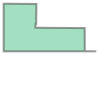

In [239]:
list(bounds.difference(unary_union(elm['geometry'])).geoms)[1]

In [47]:
b5_12:shapely.geometry.polygon.Polygon = nush[(nush['amenity']=="classroom") & (nush['name']=="D5-05")]['geometry'].iloc[0]
b5_13:shapely.geometry.polygon.Polygon = nush[(nush['amenity']=="classroom") & (nush['name']=="D4-06")]['geometry'].iloc[0]
b5_12.intersection(b5_13).wkt

'LINESTRING (103.76921428683 1.30672215664, 103.76921591756 1.30680008554)'

In [52]:
nush.iloc[34]['neighbor']

[108, 483, 568, 841]

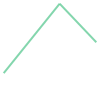

In [58]:
nush.iloc[34:35]['geometry'].iloc[0].intersection(nush.iloc[841:842]['geometry'].iloc[0])

C:\Users\picokatx\AppData\Local\Temp\ipykernel_15256\1425441235.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


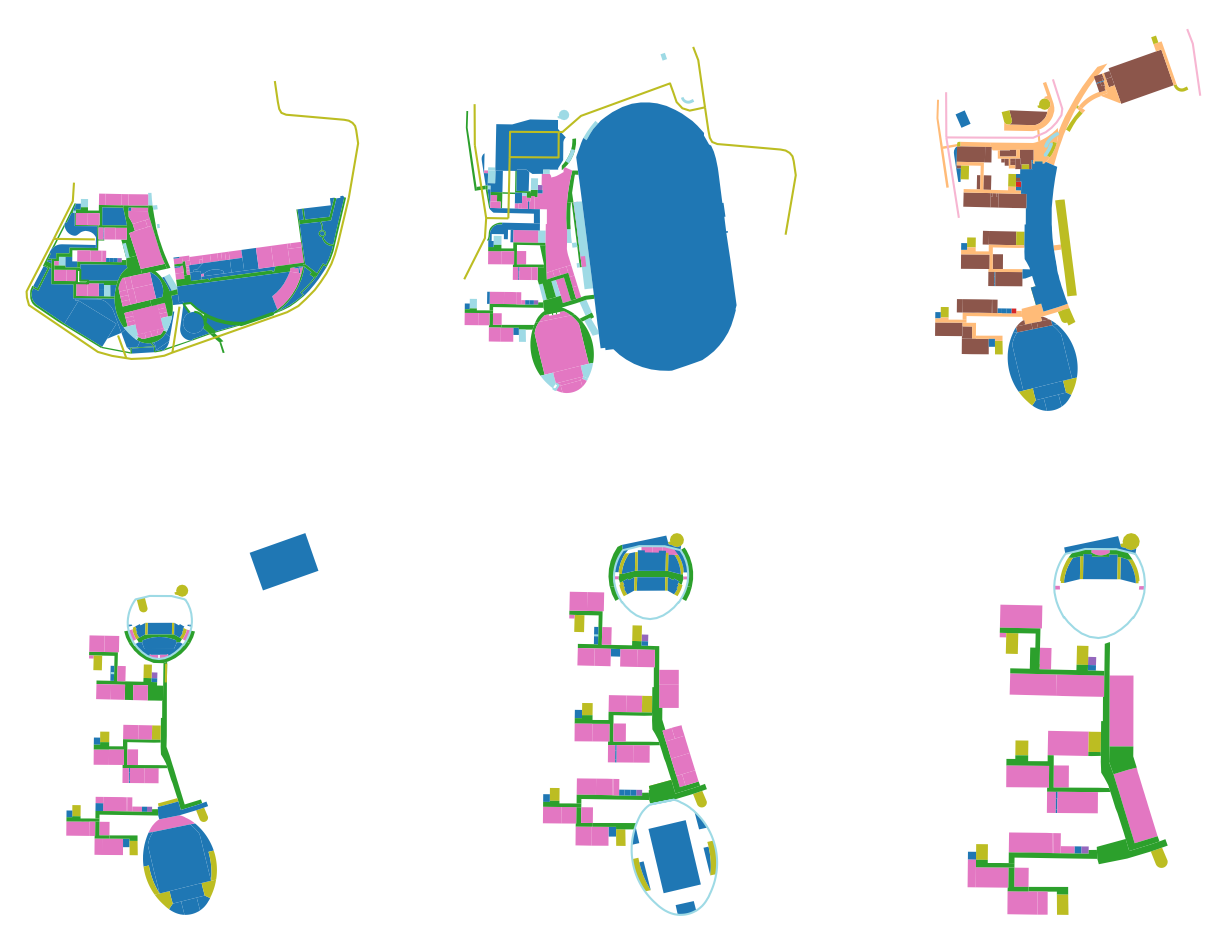

In [166]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
level = 1
for ax in ax.flat:
    corridors = nush[
    # ((nush['indoor']=='corridor') | (nush['indoor']=='area') | (nush['indoor']=='steps')) & (nush['landuse']!="void") & ((nush['landuse']=="void_deck") | (nush['landuse'].isna())) & 
    ((level>=nush['level'].str[0].astype(float)) & (level<=nush['level'].str[1].astype(float)))
    ]
    ax = corridors.plot(figsize=(16,16), column="indoor", cmap="tab20", ax=ax)
    ax.set_axis_off()
    fig.add_subplot(ax)
    level+=1
fig.show()

## wifi

In [90]:
metadata = subprocess.check_output(['netsh', 'wlan', 'show', 'networks','mode=Bssid'])
data = metadata.decode('utf-8', errors ="backslashreplace").split('\n')
bssids = []
temp = []
recording = False
record_signal_on_next_line = False
for i in data:
    if record_signal_on_next_line:
        temp.append(i.split(":")[1].strip())
        bssids.append(temp)
        temp=[]
        record_signal_on_next_line = False
    if i[0:4]=="SSID":
        recording="NET30R" in i
    if i[0:9]=="    BSSID" and recording:
        temp.append(i.split(" : ")[1].strip())
        record_signal_on_next_line = True
bssids

[['e4:f0:42:d1:56:27', '89%'], ['e4:f0:42:d1:56:23', '89%']]

## gps

In [2]:
bbox = (1.3055, 1.3080, 103.76865, 103.77117)

In [3]:
lv6_features = pd.read_csv("./data/lv6_features.csv", sep=";")

In [4]:
lv6_features

,altitude,altitudeApi,cityPostcode,country,horizontalAccuracy,latitude,locationReadTime,longitude,name,numberOfSatellites,numberOfUsedSatellites,rawProvider,saveTime,streetWithHouseNumber,tags,verticalAccuracy
0,16.525706,13.0,Singapore 129957,Singapore,5.750000,1.306181,2024-07-11T01:37:36.900Z,103.769361,E6_stairs_end,30,14,Fused,2024-07-11T01:38:31.453Z,Clementi Avenue 1 20,E,8.785066
1,41.526084,8.0,Singapore 129957,Singapore,3.416000,1.306111,2024-07-11T01:39:37.911Z,103.769263,E6_instrument_room,29,22,Fused,2024-07-11T01:40:00.933Z,Clementi Avenue 1 20,E,100.000366
2,16.526216,13.0,Singapore 129957,Singapore,5.900000,1.306213,2024-07-11T01:41:10.865Z,103.769259,E6_fe_1,26,22,Fused,2024-07-11T01:41:34.711Z,Clementi Avenue 1 20,E,10.215747
3,16.526413,13.0,Singapore 129957,Singapore,3.916000,1.306241,2024-07-11T01:42:08.872Z,103.769223,E6_life_science_lab_back,25,21,Fused,2024-07-11T01:42:28.519Z,Clementi Avenue 1 20,E,10.795633
4,18.527362,8.0,Singapore 129957,Singapore,9.083000,1.306262,2024-07-11T01:44:19.941Z,103.769023,E6_life_sciences_lab_front,18,11,Fused,2024-07-11T01:44:31.961Z,Clementi Avenue 1 20,NaN,100.000366
5,22.827095,8.0,Singapore 129957,Singapore,41.148998,1.306315,2024-07-11T01:45:15.028Z,103.769093,E6-12_front,14,14,Fused,2024-07-11T01:45:29.456Z,Clementi Avenue 1 20,E,3.575783
6,23.226182,8.0,Singapore 129957,Singapore,8.750000,1.306040,2024-07-11T01:46:49.907Z,103.769225,E6_12_back,17,9,Fused,2024-07-11T01:47:01.354Z,Clementi Avenue 1 20,E,3.025791
7,22.827427,13.0,Singapore 129957,Singapore,15.142000,1.306218,2024-07-11T01:48:56.476Z,103.768998,E6_analytical_chemistry_lab_back_and_prep_room,14,11,Fused,2024-07-11T01:49:31.068Z,Clementi Avenue 1 20,NaN,3.380339
8,19.727129,13.0,Singapore 129957,Singapore,3.585000,1.306252,2024-07-11T01:49:56.939Z,103.769071,E6_analytical_chemistry_lab_front,28,19,Fused,2024-07-11T01:50:13.284Z,Clementi Avenue 1 20,E,6.919340
9,19.927349,13.0,Singapore 129957,Singapore,4.761000,1.306222,2024-07-11T01:50:40.857Z,103.769017,E6_synthetic_chemistry_lab_back,29,19,Fused,2024-07-11T01:51:03.242Z,Clementi Avenue 1 20,E,2.206200


In [42]:
lv6_features_df = geopandas.GeoDataFrame({"name": lv6_features['name'].to_list()}, geometry=[shapely.geometry.Point(x,y) for y,x in lv6_features[['latitude', 'longitude']].to_dict('tight')['data']])
lv6_features_df

,name,geometry
0,E6_stairs_end,POINT (103.76936 1.30618)
1,E6_instrument_room,POINT (103.76926 1.30611)
2,E6_fe_1,POINT (103.76926 1.30621)
3,E6_life_science_lab_back,POINT (103.76922 1.30624)
4,E6_life_sciences_lab_front,POINT (103.76902 1.30626)
5,E6-12_front,POINT (103.76909 1.30631)
6,E6_12_back,POINT (103.76922 1.30604)
7,E6_analytical_chemistry_lab_back_and_prep_room,POINT (103.769 1.30622)
8,E6_analytical_chemistry_lab_front,POINT (103.76907 1.30625)
9,E6_synthetic_chemistry_lab_back,POINT (103.76902 1.30622)


## Testing OSM data

In [43]:
# barrier: can find all gates+turnstiles
# amenities: Some useful boundaries
# building: Most buildings
# highway: Most highways
# leisure: field, some courts
# sport: overlap with leisure, I think it's more or less the same

# man_made: Observatory
# office: General Office
# public_transport: One of the bus stops, not sure which



# landuse: highlights nush boarding for some reason
# natural: One of the ponds
# shop: shows laundry for some reason
# tourism: BOarding is a tourist destination real
# water: same pond as natural tag
# waterway: where is this waterway? there's one but ??? where is it

In [44]:
temp = ox.features_from_bbox(None, None, None, None, bbox, tags = {'waterway': True})
temp

,,nodes,waterway,geometry
element_type,osmid,,,
way,1021818949,"[11925609732, 11925609736, 11925609745, 119256...",stream,"LINESTRING (103.76883 1.30745, 103.76896 1.306..."


<Axes: >

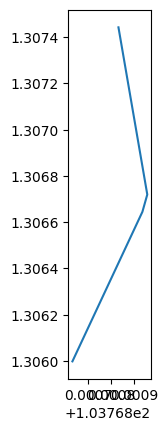

In [45]:
temp.plot()

In [46]:
df_grass: pd.DataFrame = ox.features_from_bbox(None, None, None, None, bbox, tags = {'leisure': True})
df_grass = pd.concat([df_grass.loc['node'], df_grass.loc['way'], df_grass.loc['relation']])
df_grass['color'] = [tuple(rgba/255 for rgba in (0, 0, 0, 64))]*len(df_grass)
df_grass

,leisure,level,geometry,nodes,sport,name,name:zh,surface,ways,type,color
osmid,,,,,,,,,,,
10586920888,fitness_centre,0,POINT (103.76957 1.30694),NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
10586920903,outdoor_seating,NaN,POINT (103.77018 1.30621),NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
736557965,pitch,NaN,"POLYGON ((103.76902 1.30587, 103.76926 1.30571...","[6896176835, 6896176836, 6896176837, 689617683...",basketball,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
949082628,sports_centre,NaN,"POLYGON ((103.76989 1.30745, 103.77022 1.30757...","[8785708450, 9154705535, 8785708451, 108466898...",basketball;volleyball;netball,Indoor Sports Hall,室内体育场,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
1091853849,swimming_pool,NaN,"POLYGON ((103.76868 1.30708, 103.76875 1.30709...","[9999601873, 9999601874, 9999601875, 999960187...",NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
1127708804,pitch,4,"POLYGON ((103.76936 1.30612, 103.76949 1.30616...","[10310454089, 10310454090, 10310454091, 103104...",netball,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
1127708805,pitch,5,"POLYGON ((103.76937 1.30658, 103.76946 1.3066,...","[10310454093, 10310454094, 10310454095, 103104...",tennis,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
1127708806,pitch,5,"POLYGON ((103.76937 1.30702, 103.76945 1.30702...","[10310454097, 10310454098, 10310454099, 103104...",tennis,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"
1135724727,garden,NaN,"POLYGON ((103.77063 1.30655, 103.77066 1.30626...","[10586920904, 10586952305, 10586952306, 105869...",NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 0.0, 0.25098039215686274)"


In [47]:
df_amenity: pd.DataFrame = ox.features_from_bbox(None, None, None, None, bbox, tags = {'amenity': True})
df_amenity_way = df_amenity.loc['way']
df_amenity_node = df_amenity.loc['node']
df_amenity_way['color'] = [tuple(rgba/255 for rgba in (i*40, 0, 255, 64)) for i in range(len(df_amenity_way))]
df_amenity_node['color'] = [tuple(rgba/255 for rgba in (0, 255, 0, 255))]*len(df_amenity_node)
df_amenity = pd.concat([df_amenity_way, df_amenity_node])
df_amenity = df_amenity[df_amenity.index!=173551127]  # Get rid of Nan Hua
df_amenity = df_amenity[df_amenity.index!=679649062]  # Get rid of Church of the Holy Cross
df_amenity_way

c:\Users\picokatx\Documents\dashboard\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\picokatx\Documents\dashboard\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,amenity,check_date,denomination,name,religion,geometry,level,nodes,name:zh,wikidata,...,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,school,building,fast_food,theatre:type,color
osmid,,,,,,,,,,,,,,,,,,,,,
173551126,school,NaN,NaN,NUS High School of Mathematics and Science,NaN,"POLYGON ((103.76885 1.30745, 103.76898 1.30672...",NaN,"[1843451235, 1843451119, 11925609737, 18434510...",国大附属数理中学,Q6955645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0, 1.0, 0.25098039215686274)"
173551127,school,NaN,NaN,Nan Hua High School,NaN,"POLYGON ((103.76792 1.30878, 103.77001 1.30917...",NaN,"[1843451447, 1843451486, 1843451326, 184345127...",南华中学,Q6962212,...,Singapore,SG,41,129956,Clementi Avenue 1,secondary,NaN,NaN,NaN,"(0.1568627450980392, 0.0, 1.0, 0.2509803921568..."
949250082,fast_food,NaN,NaN,Canteen,NaN,"POLYGON ((103.76991 1.30616, 103.77008 1.30618...",NaN,"[8787761899, 10586920873, 8787761900, 87877619...",食堂,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,school,cafeteria,NaN,"(0.3137254901960784, 0.0, 1.0, 0.2509803921568..."
1127708802,theatre,NaN,NaN,Amphitheatre,NaN,"POLYGON ((103.76981 1.30595, 103.76977 1.3059,...",NaN,"[10310454075, 10310454076, 10310454077, 103104...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amphi,"(0.47058823529411764, 0.0, 1.0, 0.250980392156..."
1135724716,library,NaN,NaN,Node,NaN,"POLYGON ((103.7699 1.30623, 103.76991 1.30616,...",NaN,"[10586920876, 8787761899, 10586920873, 1058692...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,"(0.6274509803921569, 0.0, 1.0, 0.2509803921568..."


In [48]:
df_buildings: pd.DataFrame = ox.features_from_bbox(None, None, None, None, bbox, tags = {'building': True})
df_buildings = pd.concat([df_buildings.loc['way']])
df_buildings['color'] = [tuple(rgba/255 for rgba in (255, 0, 0, 255))]*len(df_buildings)
df_buildings = df_buildings[df_buildings.index!=594845783]  # Get rid of Clement Canopy
df_buildings = df_buildings[df_buildings.index!=677545623]  # Get rid of Clement Canopy
df_buildings = df_buildings[df_buildings.index!=173551135]  # Get rid of Church of the Holy Cross
df_buildings

,nodes,building,name,name:zh,geometry,building:levels,source,tourism,layer,addr:city,...,addr:postcode,addr:street,height,amenity,fast_food,level,office,ways,type,color
osmid,,,,,,,,,,,,,,,,,,,,,
173551130,"[1843451228, 7885853312, 1843451217, 850997202...",school,Block A (Auditorium),A座 (礼堂),"POLYGON ((103.76954 1.30738, 103.76955 1.30734...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
173551132,"[1843451032, 10586920897, 1843451025, 85099583...",school,Block E,E座,"POLYGON ((103.7691 1.30616, 103.76925 1.30616,...",6,Bing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
173551133,"[1843451165, 8509972052, 8509972053, 850997205...",yes,NUS High Boarding School,国大附中寄宿学校,"POLYGON ((103.77069 1.30711, 103.77073 1.30712...",NaN,Bing,hostel,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
173551134,"[1843451104, 8509958389, 8509972028, 850995839...",school,Block D,D座,"POLYGON ((103.76918 1.30662, 103.76918 1.30673...",6,Bing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
173551226,"[1843450989, 8509958356, 1843450984, 850995835...",school,Block F (Hall),F座,"POLYGON ((103.76963 1.30579, 103.7696 1.30578,...",5,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
736494345,"[8509972025, 8509972026, 1843451176, 850997202...",school,Block C (Concourse),C座 (广场),"POLYGON ((103.76933 1.30708, 103.76933 1.30706...",3,Bing,NaN,-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
916203634,"[8509958395, 8509958396, 8509958397, 850995839...",school,Block B,B座,"POLYGON ((103.76933 1.30706, 103.76928 1.30706...",5,bing,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
949250082,"[8787761899, 10586920873, 8787761900, 87877619...",school,Canteen,食堂,"POLYGON ((103.76991 1.30616, 103.77008 1.30618...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,fast_food,cafeteria,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"
1127708807,"[10310454101, 10310454102, 10586920884, 105869...",grandstand,Block G,G座,"POLYGON ((103.76962 1.30698, 103.76954 1.30696...",2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0, 1.0)"


In [49]:
df_all = pd.concat([df_amenity, df_grass, df_buildings], axis=0)
df_all

,amenity,check_date,denomination,name,religion,geometry,level,nodes,name:zh,wikidata,...,sport,surface,ways,type,building:levels,source,tourism,layer,height,office
osmid,,,,,,,,,,,,,,,,,,,,,
173551126,school,NaN,NaN,NUS High School of Mathematics and Science,NaN,"POLYGON ((103.76885 1.30745, 103.76898 1.30672...",NaN,"[1843451235, 1843451119, 11925609737, 18434510...",国大附属数理中学,Q6955645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
949250082,fast_food,NaN,NaN,Canteen,NaN,"POLYGON ((103.76991 1.30616, 103.77008 1.30618...",NaN,"[8787761899, 10586920873, 8787761900, 87877619...",食堂,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1127708802,theatre,NaN,NaN,Amphitheatre,NaN,"POLYGON ((103.76981 1.30595, 103.76977 1.3059,...",NaN,"[10310454075, 10310454076, 10310454077, 103104...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135724716,library,NaN,NaN,Node,NaN,"POLYGON ((103.7699 1.30623, 103.76991 1.30616,...",NaN,"[10586920876, 8787761899, 10586920873, 1058692...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10586920872,toilets,NaN,NaN,NaN,NaN,POINT (103.77034 1.30619),0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10586952322,theatre,NaN,NaN,Theatrette,NaN,POINT (103.7695 1.30594),0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10586920888,NaN,NaN,NaN,NaN,NaN,POINT (103.76957 1.30694),0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10586920903,NaN,NaN,NaN,NaN,NaN,POINT (103.77018 1.30621),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736557965,NaN,NaN,NaN,NaN,NaN,"POLYGON ((103.76902 1.30587, 103.76926 1.30571...",NaN,"[6896176835, 6896176836, 6896176837, 689617683...",NaN,NaN,...,basketball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
geom: shapely.geometry.polygon.Polygon = df_all['geometry'][173551126]

In [51]:
[(float(strnum.split(" ")[0]), float(strnum.split(" ")[1])) for strnum in geom.wkt.replace("POLYGON ((", "").replace("))", "").split(", ")]

[(103.7688531, 1.3074524),
 (103.768975, 1.3067154),
 (103.7689552, 1.3066427),
 (103.7686658, 1.3060214),
 (103.7686685, 1.3060038),
 (103.7686765, 1.3059851),
 (103.7686864, 1.3059701),
 (103.7691443, 1.3056605),
 (103.7692289, 1.3056214),
 (103.7692899, 1.3056013),
 (103.769347, 1.3055915),
 (103.769429, 1.3055847),
 (103.7695051, 1.3055913),
 (103.7695915, 1.3056085),
 (103.7700102, 1.3057568),
 (103.7704774, 1.3059171),
 (103.7705728, 1.305971),
 (103.7706554, 1.3060429),
 (103.7707145, 1.306111),
 (103.770786, 1.3062202),
 (103.7708364, 1.3063282),
 (103.7708712, 1.3064679),
 (103.7709247, 1.3064644),
 (103.7709574, 1.3064695),
 (103.7709783, 1.3064813),
 (103.7709886, 1.3064974),
 (103.7709918, 1.3065239),
 (103.7710857, 1.306919),
 (103.7711576, 1.3073391),
 (103.7710443, 1.3073458),
 (103.7704746, 1.3073793),
 (103.7703994, 1.3079119),
 (103.7695892, 1.3076073),
 (103.7692547, 1.3074839),
 (103.7690633, 1.3074491),
 (103.7689481, 1.3074464),
 (103.7689304, 1.3074472),
 (103.76

## Glob Display

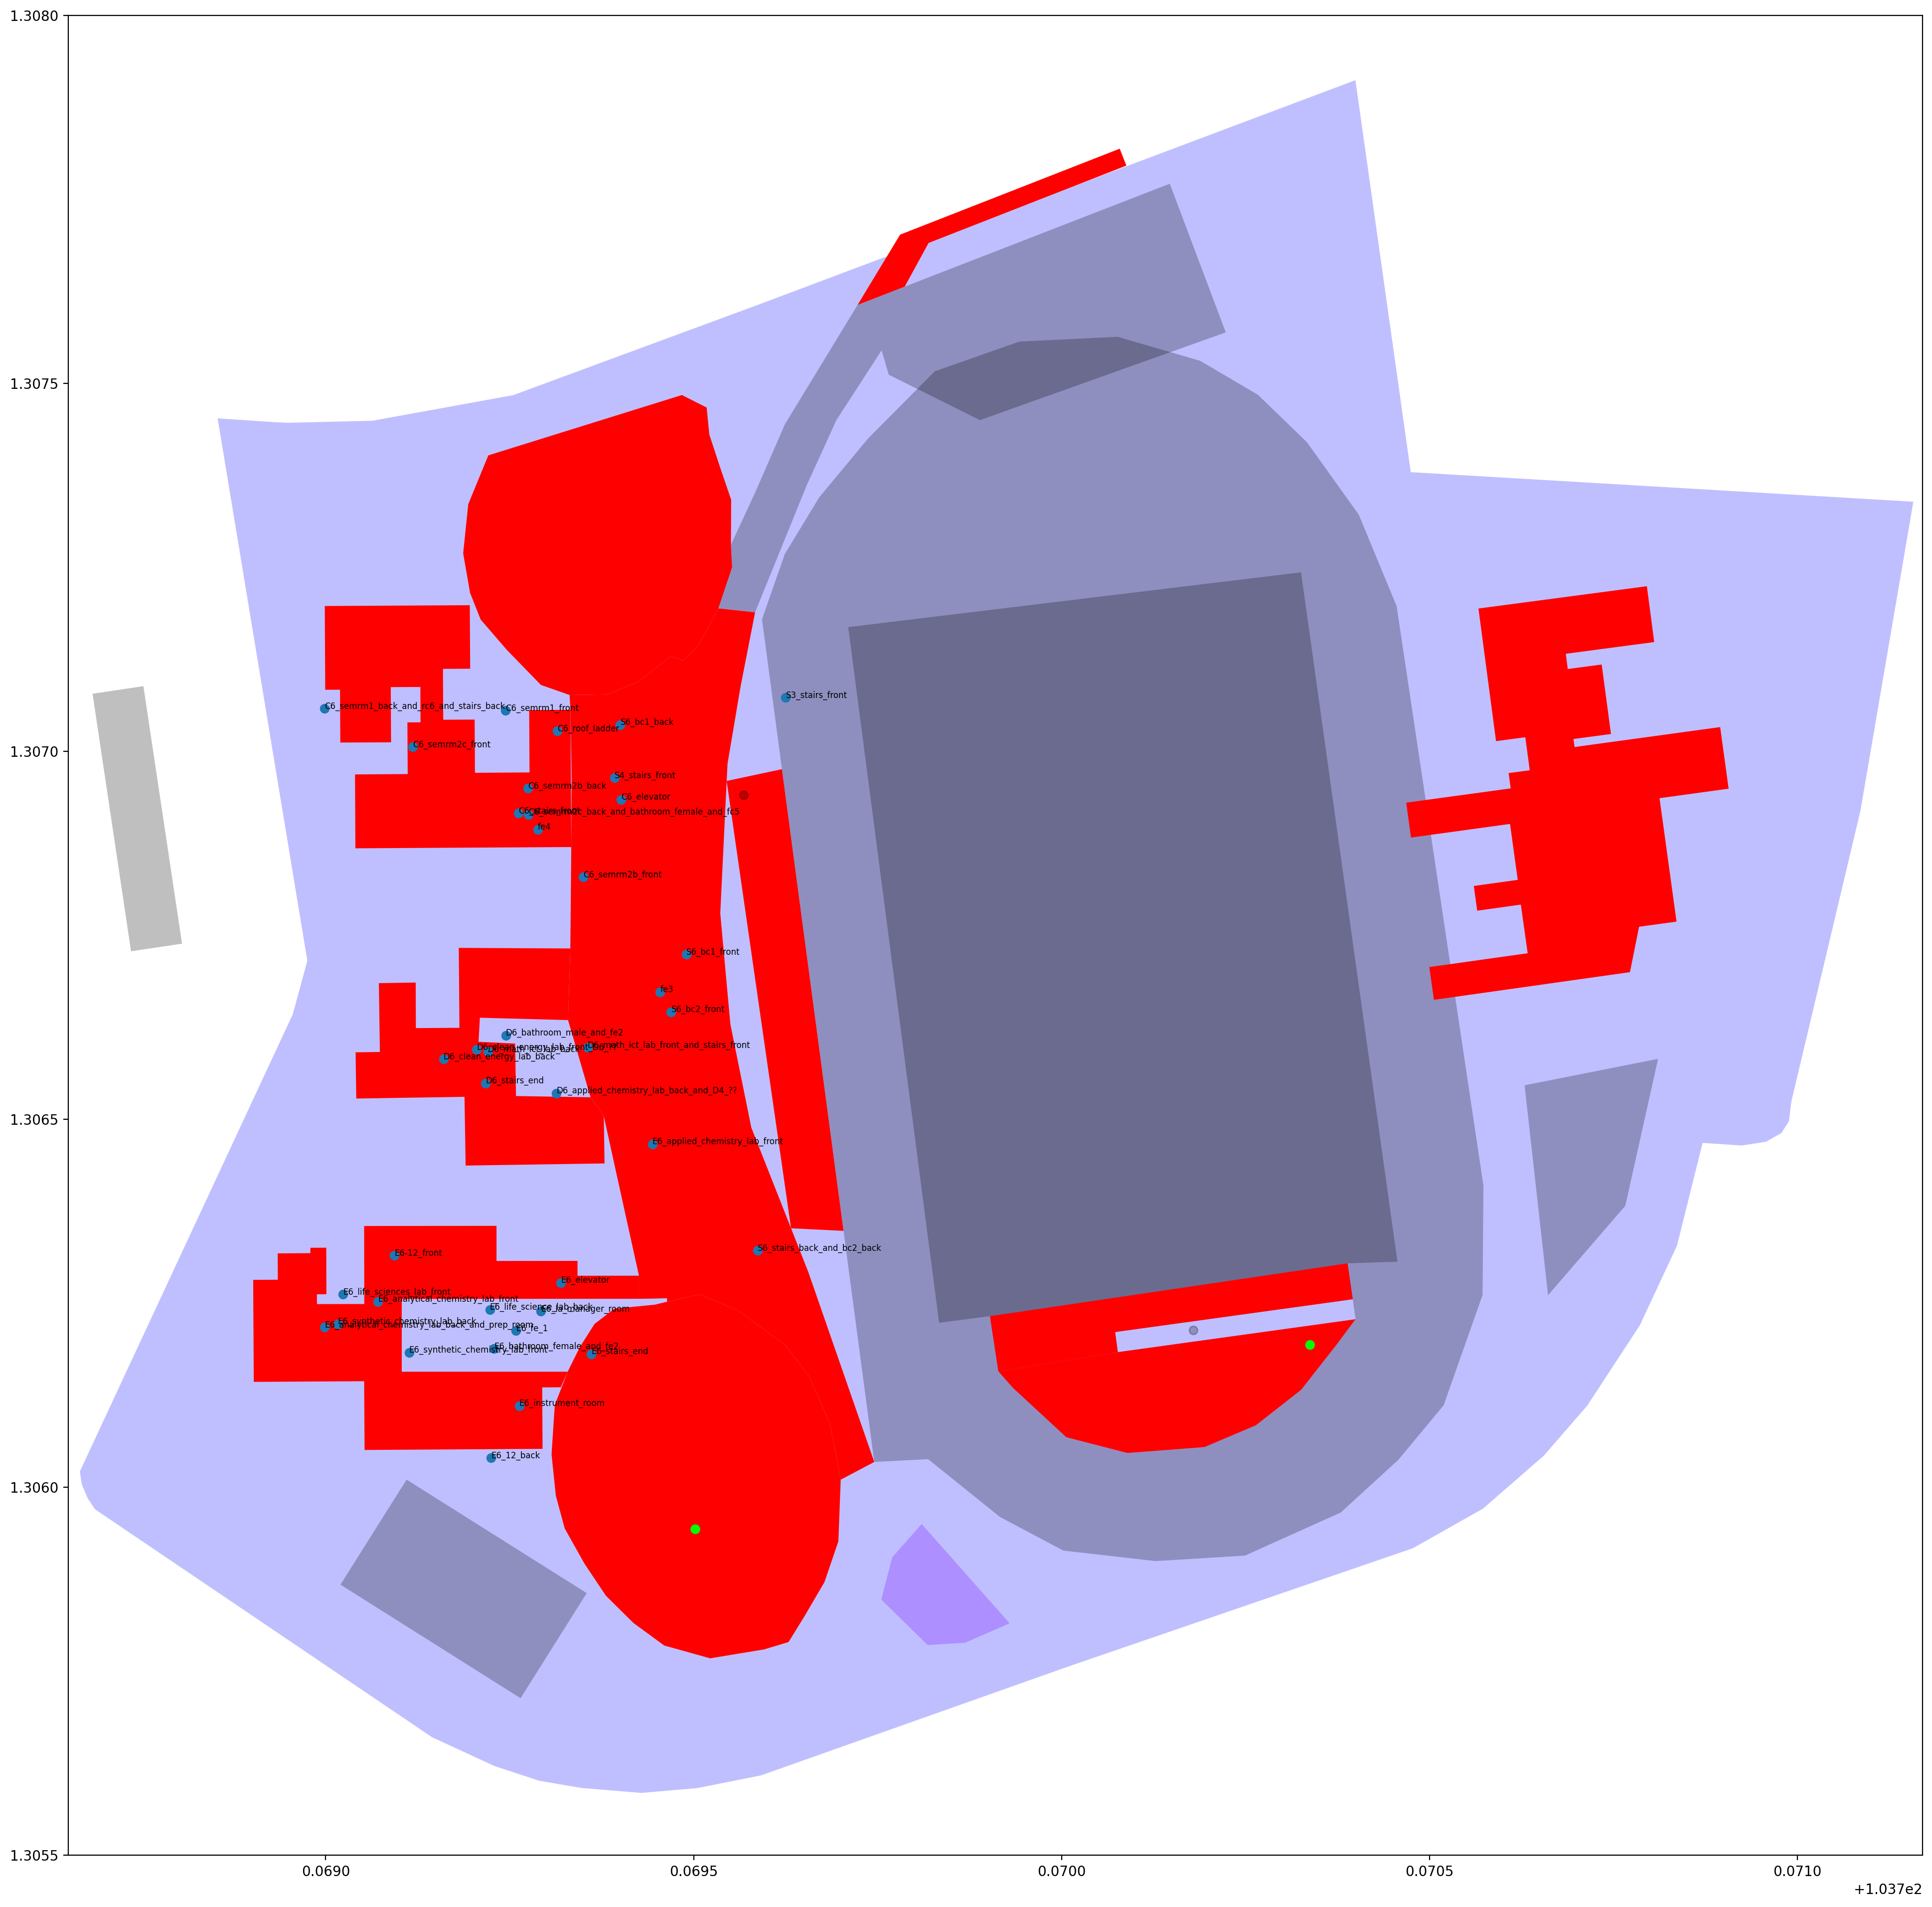

In [54]:
fig, ax = plt.subplots()
ax.autoscale(enable=True)
ax.axis((bbox[2], bbox[3], bbox[0], bbox[1]))
fig.set_size_inches(24,24)
fig.set_dpi(200)
df_all.plot(color=df_all['color'], figsize=(24,24), ax=ax)
lv6_features_df.plot(ax=ax)
for row in lv6_features_df.itertuples():
    name = row.name
    point = row.geometry
    ax.annotate(name, (point.x, point.y), fontsize=6)

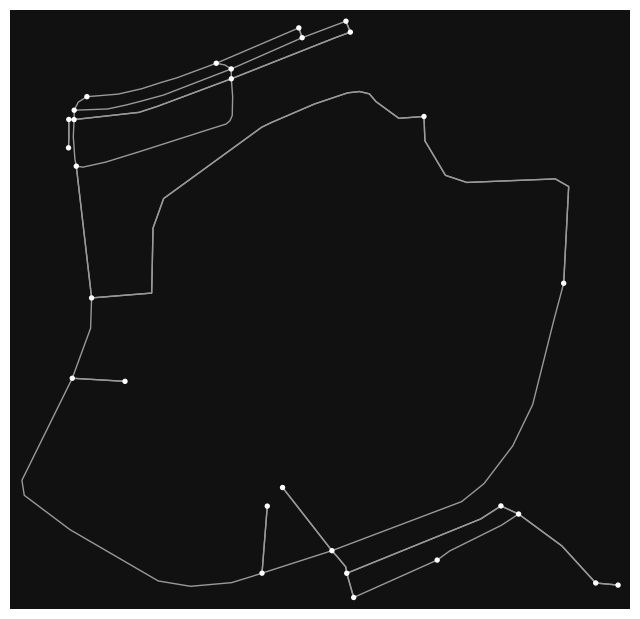

In [5]:
G = ox.graph_from_bbox(None, None, None, None, bbox, "all")
fig, ax = ox.plot_graph(G)

In [6]:
ox.basic_stats(G)

{'n': 29,
 'm': 53,
 'k_avg': 3.6551724137931036,
 'edge_length_total': 2469.7619999999993,
 'edge_length_avg': 46.59928301886791,
 'streets_per_node_avg': 3.0344827586206895,
 'streets_per_node_counts': {0: 0, 1: 4, 2: 1, 3: 14, 4: 10},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.13793103448275862,
  2: 0.034482758620689655,
  3: 0.4827586206896552,
  4: 0.3448275862068966},
 'intersection_count': 25,
 'street_length_total': 1668.5869999999998,
 'street_segment_count': 35,
 'street_length_avg': 47.67391428571428,
 'circuity_avg': 1.0986295007816296,
 'self_loop_proportion': 0.0}